In [34]:
import pandas as pd
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold 
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool
from functools import partial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import clone
import shap 

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv', sep=',')
df.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


In [3]:
df.winpercent = df.winpercent/100

In [4]:
df.dtypes

competitorname       object
chocolate             int64
fruity                int64
caramel               int64
peanutyalmondy        int64
nougat                int64
crispedricewafer      int64
hard                  int64
bar                   int64
pluribus              int64
sugarpercent        float64
pricepercent        float64
winpercent          float64
dtype: object

In [5]:
df.isna().sum()

competitorname      0
chocolate           0
fruity              0
caramel             0
peanutyalmondy      0
nougat              0
crispedricewafer    0
hard                0
bar                 0
pluribus            0
sugarpercent        0
pricepercent        0
winpercent          0
dtype: int64

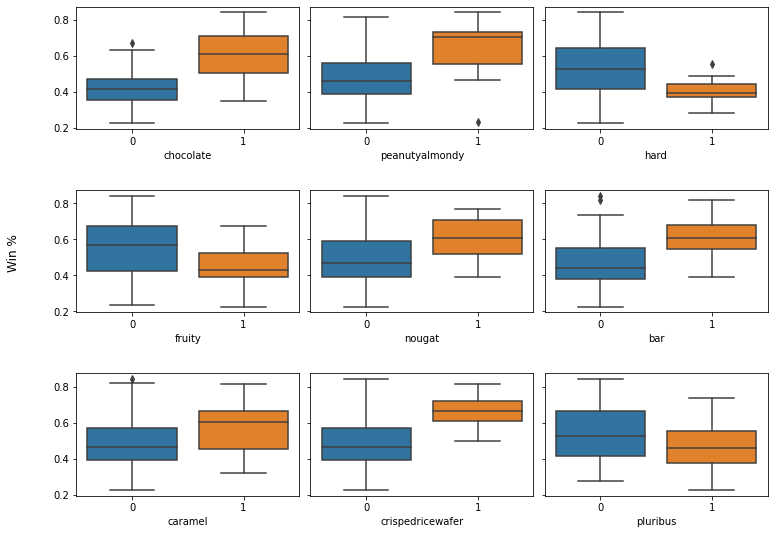

In [6]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(12,9))
for i, c in enumerate(df.select_dtypes('int').columns):
    sns.boxplot(x=c, y='winpercent', data=df, ax=axs[i%3, int(np.floor(i/3))]).set(ylabel=None)
    
fig.supylabel('Win %')
plt.subplots_adjust(hspace=0.5, wspace=0.05, left=0.1)

Text(0.02, 0.5, 'Win %')

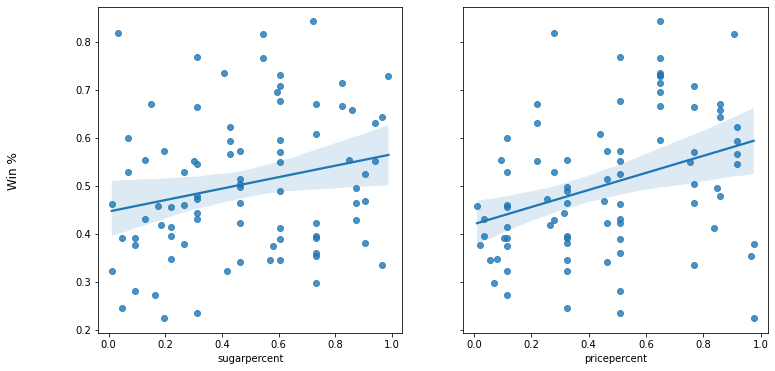

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(12,6))

sns.regplot(x='sugarpercent', y='winpercent', data=df, ax=axs[0]).set(ylabel=None)
sns.regplot(x='pricepercent', y='winpercent', data=df, ax=axs[1]).set(ylabel=None)

fig.supylabel('Win %')

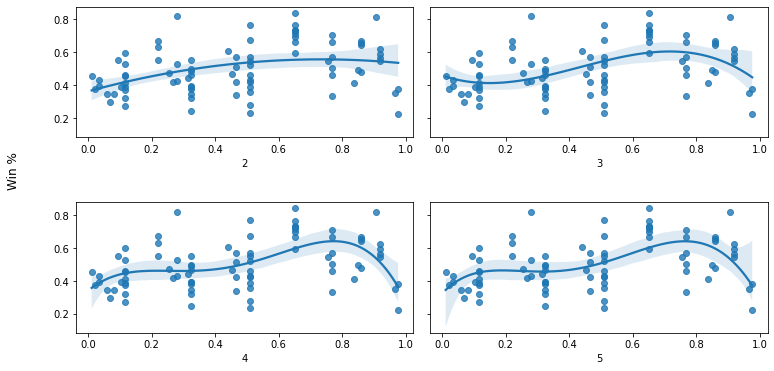

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(12,6))
for order in range(2,6):
    i = order-2
    sns.regplot(x='pricepercent', y='winpercent', data=df, order=order, ax=axs[int(np.floor(i/2)), i%2]).set(ylabel=None, xlabel=order)
fig.supylabel('Win %')
plt.subplots_adjust(hspace=0.5, wspace=0.05, left=0.1)

In [9]:
X = df.drop(columns=['competitorname', 'winpercent'])
y = df.winpercent

In [10]:
## calculate adjusted R squared
def adjusted_r2(y, preds, p):
    r2 = r2_score(y, preds)
    n = len(y)
    
    adj = 1-(1-r2)*(n-1)/(n-p-1)
    return adj

In [11]:
## display a regression table with coefficients, t-values and p-values
def regression_table(model, X, y):
    model.fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    preds = model.predict(X)
    
    adj_r2 = adjusted_r2(y, preds, X.shape[1])
    print('adjusted R2: {:.4f}.'.format(adj_r2))
    
    n = len(X)
    
    beta = [model.intercept_] + model.coef_.tolist()
    X1 = np.column_stack((np.ones(n), X))
    
    sigma_hat = np.sqrt(np.sum(np.square(y - X1@beta)) / (n - X1.shape[1]))
    
    beta_cov = np.linalg.inv(X1.T@X1)
    
    t_vals = beta / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
    p_vals = t.sf(np.abs(t_vals), n-X1.shape[1])*2 
    
    
    out = pd.DataFrame(zip(X.columns.values, model.coef_.tolist(), np.around(t_vals, 2), np.around(p_vals, 4)), columns=['feature', 'coef', 'T', 'p'])
    return out.set_index('feature')

### Leave-one-out cross-validation
To assess out-of-sample error rates it is necessary to test the model against unknown data. The dataset is extremely small, so holdout sets and regular k-fold cross validation are not feasible. Leave-one-out cross-validation is a possible alternative for very small datasets.

In [12]:
def loocv(model, X, y):
    preds = []
    for i in range(len(X)):
        model.fit(X.drop(i).values, y.drop(i).values)
        p = model.predict(X.iloc[i].values.reshape(1, -1))
        preds.append(p)
    
    r2 = r2_score(y, preds)
    adj_r2 = adjusted_r2(y, preds, X.shape[1])

    return r2, adj_r2

In [13]:
## GridSearchCV cant handle loo-cv with R² since the score is calculated after each fold
## I make a custom grid-search function with multithreading
def get_score(p, model, X, y):
    model_copy = clone(model)
    model_copy.set_params(**p)
    _, adj_r2 = loocv(model_copy, X, y)
    return adj_r2

def loogridsearch(model, X, y, params, n_jobs=6):
    scores = []
    grid = ParameterGrid(params)
    
    with Pool(n_jobs) as p:
        f = partial(get_score, model=model, X=X, y=y)
        scores = p.map(f, list(grid))
    
    ix = scores.index(max(scores))

    return scores, scores[ix], list(grid)[ix]

## Linear Regression

In [14]:
lm = LinearRegression()

In [15]:
regression_table(lm, X, y)

adjusted R2: 0.4709.


,coef,T,p
feature,,,
chocolate,0.197481,7.99,0.0000
fruity,0.094223,5.07,0.0000
caramel,0.022245,2.50,0.0145
peanutyalmondy,0.100707,0.61,0.5449
nougat,0.008043,2.79,0.0068
crispedricewafer,0.089190,0.14,0.8885
hard,-0.061653,1.69,0.0947
bar,0.004415,-1.78,0.0785
pluribus,-0.008545,0.09,0.9307


In [16]:
_, score = loocv(lm, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2538


### Regularization

In [17]:
ridge = Ridge()

In [18]:
_, score = loocv(ridge, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2869


### Polynomial features

In [19]:
poly = PolynomialFeatures(4, include_bias=False)
X[['pricepercent', 'pricepercent2', 'pricepercent3', 'pricepercent4']] = poly.fit_transform(pd.DataFrame(X['pricepercent']))

In [20]:
regression_table(lm, X, y)

adjusted R2: 0.4914.


,coef,T,p
feature,,,
chocolate,0.202551,3.53,0.0008
fruity,0.087414,5.28,0.0000
caramel,0.008463,2.30,0.0242
peanutyalmondy,0.070382,0.23,0.8172
nougat,0.008197,1.81,0.0749
crispedricewafer,0.079406,0.14,0.8901
hard,-0.049729,1.52,0.1327
bar,-0.003544,-1.44,0.1542
pluribus,-0.005667,-0.07,0.9452


In [21]:
_, score = loocv(lm, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2161


In [22]:
_, score = loocv(ridge, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2645


### Hyperparameter tuning

In [23]:
X = df.drop(columns=['competitorname', 'winpercent'])
y = df.winpercent

In [24]:
_, score = loocv(ridge, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2869


In [25]:
ridge = Ridge()

In [26]:
params = {'alpha':[0.1, 1.0, 2.0, 2.2, 2.5, 2.7, 3.0]}
scores, best_score, best_params = loogridsearch(ridge, X, y, params)

print('Best score: {:.4f}'.format(best_score))
print('Best Params: {}'.format(best_params))

Best score: 0.2957
Best Params: {'alpha': 2.5}


In [27]:
ridge = Ridge(**best_params)
ridge.fit(X, y)
preds = ridge.predict(X)
score = adjusted_r2(y, preds, X.shape[1])
print('adjusted R2 on full set: {:.4f}'.format(score))

adjusted R2 on full set: 0.4451


## Random Forest

In [28]:
rf = RandomForestRegressor()

In [29]:
_, score = loocv(rf, X, y)
print('LOO-CV adjusted R2: {:.4f}'.format(score))

LOO-CV adjusted R2: 0.2844


In [92]:
params = {'max_depth': [10, 20, 30],
          'n_estimators': [30, 50, 100, 200],
          'max_features': ['sqrt', 'log2']}

scores, best_score, best_params = loogridsearch(rf, X, y, params)

print('Best score: {:.4f}'.format(best_score))
print('Best Params: {}'.format(best_params))

Best score: 0.3248
Best Params: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 50}


In [96]:
rf = RandomForestRegressor(**best_params)
rf.fit(X,y)
score = rf.score(X,y)
print('adjusted R2 on full set: {:.4f}'.format(score))

adjusted R2 on full set: 0.8918


### Model interpretation

In [88]:
explainer = shap.TreeExplainer(rf)

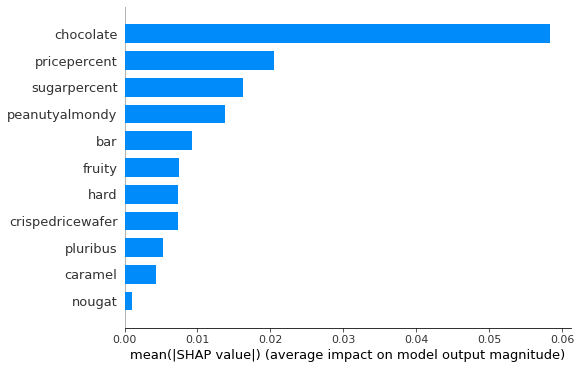

In [90]:
shap_values = shap.TreeExplainer(rf).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

In [86]:
view = df.loc[[df.winpercent.idxmax()]].drop(columns=['competitorname'])
shap_values = explainer.shap_values(view)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], view)

In [73]:
view = df.loc[[df.winpercent.idxmin()]].drop(columns=['competitorname'])
shap_values = explainer.shap_values(view)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], view)

In [82]:
view = df.loc[[33]].drop(columns=['competitorname'])
shap_values = explainer.shap_values(view)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], view)

Save model.

In [98]:
from joblib import dump, load
dump(rf, 'random_forest.joblib') 

['random_forest.joblib']